# Taux-SSH_feedback: 

coupling between Taux anomalies in the western equatorial Pacific and SSH anomalies in the eastern equatorial Pacific. Computes sea surface height anomalies (SSHA; used as a proxy for subsurface temperature) in the eastern equatorial Pacific (horizontal Niño3 average) regressed onto zonal wind stress anomalies (TauxA) in the western equatorial Pacific (horizontal Niño4 average).

#### Reference observations:
TropFlux and AVISO 1993-2018 (main)

SSH: JPL-MEASURES 1993-2021, CSIRO-SSH 1993-2019, GODAS 1980-2023, ORAS5 1958-2022, SODA3.4.2 1979-2018

Taux: ERA5 1940-2022, 20CRv3 1836-2015, NCEP2 1979-2023


In [1]:
from esmvalcore.dataset import Dataset

from esmvalcore.config import CFG
CFG['rootpath']['OBS6'].append(r'/g/data/kj13/datasets/esmvaltool/obsdata-v2') #staging zos

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/esmvalcore/config/_config_object.py:639: ESMValCoreDeprecationWarning: Usage of the single configuration file ~/.esmvaltool/config-user.yml or specifying it via CLI argument `--config_file` has been deprecated in ESMValCore version 2.12.0 and is scheduled for removal in version 2.14.0. Please run `mkdir -p ~/.config/esmvaltool && mv /home/189/fc6164/.esmvaltool/config-user.yml ~/.config/esmvaltool` (or alternatively use a custom `--config_dir`) and omit `--config_file`.
  config_obj.reload()
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/esmvalcore/config/_config_validators.py:405: ESMValCoreDeprecationWarning: The configuration option or command line argument `config_file` has been deprecated in ESMValCore version 2.12.0 and is scheduled for removal in version 2.14.0. Please use the option `config_dir` instead.
  _handle_deprecation(option, deprecated_version, rem

In [2]:
model_ssh_datasets = { 
"ACCESS-ESM1-5": 
    Dataset(
    short_name='zos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20140101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

#tauu
model_tauu = {"ACCESS-ESM1-5": 
    model_ssh_datasets["ACCESS-ESM1-5"].copy(short_name='tauu',mip="Amon")}


## obs zos required
obs_zos_datasets = {
"CMEMS": 
    Dataset(
    short_name='zos',
    dataset='CMEMS',
    mip="Omon",
    project='OBS6',
    type='sat',
    timerange="19930101/20181231",
    tier=2),

}
obs_tauu_datasets = {
 "NCEP-DOE-R2": 
     Dataset(
     short_name='tauu',
     dataset='NCEP-DOE-R2',
     mip="Amon",
     project='OBS6',
     type='reanaly',
     timerange="19930101/20181231",
     tier=2)
}

In [3]:
## ancillary variables
for name, dataset in model_tauu.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")
    
for name, dataset in model_ssh_datasets.items():
    dataset.add_supplementary(short_name='sftof', mip="Ofx")
    dataset.add_supplementary(short_name="areacello", mip="Ofx")

In [4]:
model_ssh_datasets = {name: dataset.load() for name, dataset in model_ssh_datasets.items()}
model_tauu = {name: dataset.load() for name, dataset in model_tauu.items()}

obs_zos_datasets = {name: dataset.load() for name, dataset in obs_zos_datasets.items()}
obs_tauu_datasets = {name: dataset.load() for name, dataset in obs_tauu_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/esmvalcore/config/_config_validators.py:405: ESMValCoreDeprecationWarning: The configuration option or command line argument `config_file` has been deprecated in ESMValCore version 2.12.0 and is scheduled for removal in version 2.14.0. Please use the option `config_dir` instead.
  _handle_deprecation(option, deprecated_version, remove_version, more_info)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/esmvalcore/config/_config_validators.py:405: ESMValCoreDeprecationWarning: The configuration option or command line argument `config_file` has been deprecated in ESMValCore version 2.12.0 and is scheduled for removal in version 2.14.0. Please use the option `config_dir` instead.
  _handle_deprecation(option, deprecated_version, remove_version, more_info)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/esmvalcore/config/_config_valid

In [5]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import seasonal_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_season
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import mask_landsea
from esmvalcore.preprocessor import extract_time
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np


In [6]:
def ssh_east(cube):
    nino3_region = {"start_longitude": 210., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    # cube = extract_time(cube, start_year=1979, end_year=2000, start_month=1, end_month=12, start_day=1, end_day=31)
    cube = regrid(cube, target_grid="1x1", scheme="linear") # helps with obs resolution
    cube = convert_units(cube, units="cm")
    # cube = mask_landsea(cube, mask_out="land")
    cube = anomalies(cube, period="monthly")
    cube = detrend(cube, dimension="time", method="linear")
    cube = extract_region(cube, **nino3_region)
    cube = area_statistics(cube,operator='mean')
    
    return cube


def taux_west(cube):
    region = {"start_longitude": 160., "end_longitude": 210., "start_latitude": -5., "end_latitude": 5.}
    # cube = extract_time(cube, start_year=1979, end_year=2000, start_month=1, end_month=12, start_day=1, end_day=31)
    # cube = regrid(cube, target_grid="1x1", scheme="linear") #not req
    cube = convert_units(cube, units="1e-3 N/m2")
    cube = mask_landsea(cube, mask_out="land") 
    cube = anomalies(cube, period="monthly")
    cube = detrend(cube, dimension="time", method="linear")
    cube = extract_region(cube, **region)
    cube = area_statistics(cube,operator='mean')
    return cube   

In [7]:
model_ssh_prep = {name: ssh_east(dataset) for name, dataset in model_ssh_datasets.items()}
model_tauu_prep = {name: taux_west(dataset) for name, dataset in model_tauu.items()}

obs_zos_prep = {name: ssh_east(dataset) for name, dataset in obs_zos_datasets.items()}
obs_tauu_prep = {name: taux_west(dataset) for name, dataset in obs_tauu_datasets.items()}

In [8]:

def linreg_1d(a_cube, b_cube):
    print("cube shapes:", a_cube.shape, b_cube.shape)
    B_data = b_cube.data
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, a_cube.data, rcond=None)
    slope, intercept = coefs[0], coefs[1]
    return slope, intercept


In [9]:
# linreg_1d(obs_zos_prep["CMEMS"], obs_tauu_prep["NCEP-DOE-R2"])
B_data = obs_tauu_prep["NCEP-DOE-R2"].data
# model_tauu_prep["ACCESS-ESM1-5"].data
B_intercept = np.vstack([B_data, np.ones_like(B_data)]).T

a_data = obs_zos_prep["CMEMS"].data #449173500000.0 mean
model_ssh_prep["ACCESS-ESM1-5"].core_data()

coefs, _, _, _ = np.linalg.lstsq(B_intercept, a_data)
coefs

/jobfs/145221123.gadi-pbs/ipykernel_3162237/4033643857.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coefs, _, _, _ = np.linalg.lstsq(B_intercept, a_data)


array([ 3.8568696e-01, -9.8075213e-07], dtype=float32)

# Diagnostic Level 1

In [10]:
xseq = np.linspace(-100, 100, num=100)

mod_slope, mod_intcpt = linreg_1d(model_ssh_prep["ACCESS-ESM1-5"], model_tauu_prep["ACCESS-ESM1-5"])
# plt.plot(xseq, intcpt+slope*xseq)
print(mod_slope)

cube shapes: (420,) (420,)
0.21045984


In [11]:
slope, intcpt = linreg_1d(obs_zos_prep["CMEMS"], obs_tauu_prep["NCEP-DOE-R2"])
# plt.plot(xseq, intcpt+slope*xseq, color='black')
print(slope)

metric_val = abs((mod_slope-slope)/slope)*100

cube shapes: (312,) (312,)
0.38568696


(420,) (420,)
1e-3 N/m2 cm
(312,) (312,)
45.432472229003906


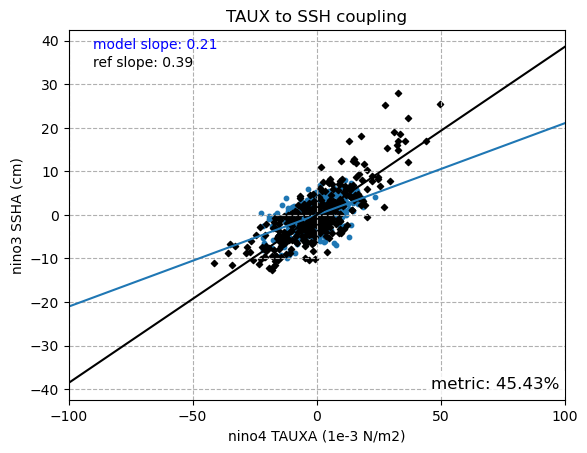

In [12]:
plt.plot(xseq, mod_intcpt + mod_slope * xseq)
plt.plot(xseq, intcpt+slope*xseq, color='black')

print(model_tauu_prep["ACCESS-ESM1-5"].shape, model_ssh_prep["ACCESS-ESM1-5"].shape) #scatter plot
print(model_tauu_prep["ACCESS-ESM1-5"].units, model_ssh_prep["ACCESS-ESM1-5"].units) #ssh cm
plt.scatter(model_tauu_prep["ACCESS-ESM1-5"].data, model_ssh_prep["ACCESS-ESM1-5"].data, s=10)
yunit = model_ssh_prep["ACCESS-ESM1-5"].units 
xunit = model_tauu_prep["ACCESS-ESM1-5"].units

print(obs_zos_prep["CMEMS"].shape, obs_tauu_prep["NCEP-DOE-R2"].shape)
plt.scatter(obs_tauu_prep["NCEP-DOE-R2"].data, obs_zos_prep["CMEMS"].data, s=10, c='black', marker='D')
plt.xlim(-100,100)
plt.xticks(np.arange(-100,110,50))
plt.title('TAUX to SSH coupling')
plt.ylabel(f'nino3 SSHA ({yunit})')
plt.xlabel(f'nino4 TAUXA ({xunit})')
plt.grid(linestyle='--')
## text slope
plt.text(0.05,0.95, f'model slope: {mod_slope:.2f}', color='blue',transform=plt.gca().transAxes)
plt.text(0.05,0.9, f'ref slope: {slope:.2f}', color='black', transform=plt.gca().transAxes)

plt.text(0.99, 0.03, f'metric: {metric_val:.2f}%', fontsize=12, ha='right',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
print(metric_val)

# Diagnostic Level 2

In [13]:
import pandas as pd

def linreg_df(var_a, var_b):
    B_data = np.array(var_b)
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, np.array(var_a), rcond=None)
    slope, intercept = coefs[0], coefs[1]
    return slope, intercept

def plt_lvl2_subplot(y_cube, x_cube, dataset_label):
    
    df = pd.DataFrame({'var_a':y_cube.data, 'var_b':x_cube.data})
    slopes = []
    print(dataset_label, 'shape: ', df.shape)
    plt.scatter(x_cube.data, y_cube.data, c='k', s=10)
    xseq = np.linspace(-100, 100, num=50)
    slope, intcpt = linreg_df(df['var_a'], df['var_b'])
    plt.plot(xseq, intcpt+slope*xseq, c='black')
    slopes.append(slope)
    
    xseq = np.linspace(-100, 0, num=50) #
    slope, intcpt = linreg_df(df.loc[df['var_b']<0, 'var_a'], df.loc[df['var_b']<0, 'var_b'])
    
    plt.plot(xseq, intcpt+slope*xseq, linewidth=3)
    slopes.append(slope)
    
    xseq = np.linspace(0, 100, num=50)
    slope, intcpt = linreg_df(df.loc[df['var_b']>0, 'var_a'], df.loc[df['var_b']>0, 'var_b'])
    plt.plot(xseq, intcpt+slope*xseq, color='red', linewidth=3)
    slopes.append(slope)

    plt.title(dataset_label)
    plt_settings(slopes)

def plt_settings(slopes):
    plt.xlim(-100,100)
    plt.xticks(np.arange(-100,110,50))
    plt.ylim(-40,40)
    plt.yticks(np.arange(-40,50,20))
    plt.grid(linestyle='--')
    plt.ylabel(f'nino3 SSHA (cm)')
    plt.xlabel(f'nino4 TAUXA (1e-3 N/m2)')
    print(slopes)
    plt.text(0.02, 0.85, f'slope(all): {slopes[0]:.2f}\nslope(x<0): {slopes[1]:.2f}\nslope(x>0): {slopes[2]:.2f}', fontsize=12, ha='left',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

ACCESS-ESM1-5 shape:  (420, 2)
[0.21045984, 0.24031821, 0.21363398]
CMEMS_NCEP-DOE-R2 shape:  (312, 2)
[0.38568696, 0.2623351, 0.49405497]


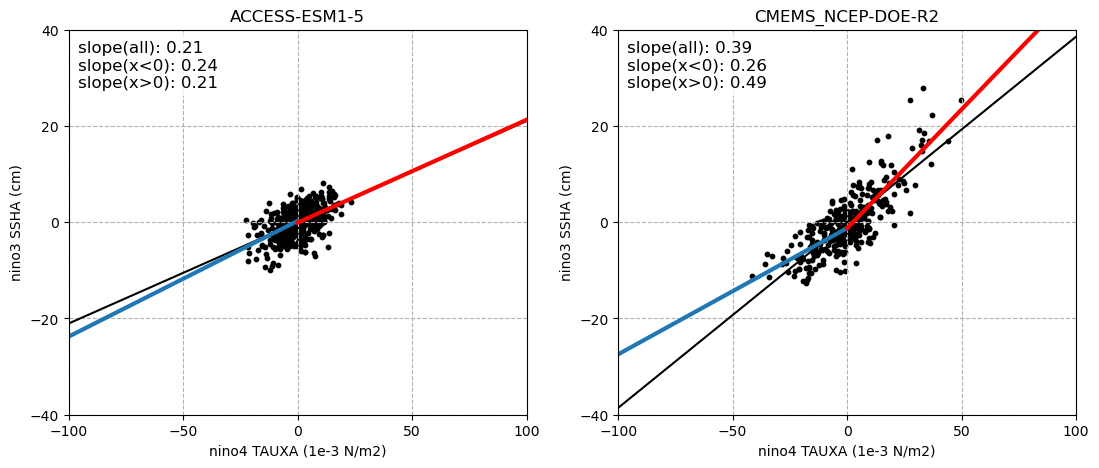

In [14]:
fig = plt.figure(figsize=(13, 5))
ax = plt.subplot(121)

plt_lvl2_subplot(model_ssh_prep["ACCESS-ESM1-5"], model_tauu_prep["ACCESS-ESM1-5"], 'ACCESS-ESM1-5')

ax = plt.subplot(122)
plt_lvl2_subplot(obs_zos_prep["CMEMS"], obs_tauu_prep["NCEP-DOE-R2"], 'CMEMS_NCEP-DOE-R2')

Figure 2: scatterplot of zonal wind stress anomalies (TauxA) in the western equatorial Pacific (Niño4 averaged) and sea surface height anomalies (SSHA) in the eastern equatorial Pacific (Niño3 averaged), showing the possible nonlinearity in the strength of the Taux-to-SSH coupling (usually shows weak nonlinearity, with a gentler slope for TauxA<0 and steeper slope for TauxA>0 in both reference and model). The black, red and blue lines and numbers show respectively linear regression computed for all TauxA, TauxA>0 and TauxA<0, the left and right scatterplots show respectively the reference and the model

## Dive down level 3
The third level shows the remote coupling in the equatorial Pacific.

In [15]:
#level 3 zonal runningaverage
from esmvalcore.preprocessor import meridional_statistics
from esmvalcore.preprocessor import mask_above_threshold, mask_below_threshold

def taua_nino4(cube):
    nino4_region = {"start_longitude": 160., "end_longitude": 210., "start_latitude": -5., "end_latitude": 5.}
    # cube = extract_time(cube, start_year=1979, end_year=2000, start_month=1, end_month=12, start_day=1, end_day=31)
    # cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = mask_landsea(cube, mask_out="land")
    cube = anomalies(cube, period="monthly")
    cube = detrend(cube, dimension="time", method="linear")
    cube = extract_region(cube, **nino4_region)
    cube = area_statistics(cube,operator='mean')    
    return cube

def ssh_eqp(cube):
    region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="cm")
    cube = mask_landsea(cube, mask_out="land") 
    cube = anomalies(cube, period="monthly")
    cube = detrend(cube, dimension="time", method="linear") # Create NaN for some reasons
    cube = extract_region(cube, **region)
    cube = meridional_statistics(cube,operator='mean')
    cube = rolling_window_statistics(cube, coordinate='longitude',operator='mean',window_length=30)
    return cube 


In [16]:
model_zos = {name: ssh_eqp(dataset) for name, dataset in model_ssh_datasets.items()}
model_tauu = {name: taua_nino4(dataset) for name, dataset in model_tauu.items()}

obs_zos = {name: ssh_eqp(dataset) for name, dataset in obs_zos_datasets.items()}
obs_tauu = {name: taua_nino4(dataset) for name, dataset in obs_tauu_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/iris/cube.py:4341: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/iris/cube.py:4896: IrisIgnoringBoundsWarning: The bounds of coordinate 'longitude' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/iris/cube.py:4341: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/iris/cube.py:4896: IrisIgnoringBoundsWarning: The bounds of coordinate 'longitude' were ignored in the rolling window operation.
  warnings.warn(


In [17]:
def lin_regress_matrix(cubeA, cubeBsst):
    
    A_data = cubeA.data.reshape(cubeA.shape[0], -1)  # Shape (time, spatial_points)
    if cubeA.shape[0] == cubeBsst.shape[0]:
        B_data = cubeBsst.data.flatten() # or all
    else:
        B_data = cubeBsst.data.compressed() # masked threshold cube (time,) 

    # Add intercept term by stacking a column of ones with cubeB
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T
    
    print('least squares data shapes ',B_with_intercept.shape, A_data.shape)
    # Solve the linear equations using least squares method
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, A_data, rcond=None)

    # Create a new Iris Cube for the regression results
    result_cube = iris.cube.Cube(coefs[0], long_name='regression SSTA,TAUXA',
                                 dim_coords_and_dims=[(cubeA.coord('longitude'), 0)])

    return result_cube


def feedback_nonlin(sst_cube, tauu_cube):
    tauu_aux = tauu_cube.copy()
    sst_coord = iris.coords.AuxCoord(sst_cube.data, sst_cube.standard_name, sst_cube.long_name, sst_cube.var_name, sst_cube.units)
    tauu_aux.add_aux_coord(sst_coord, 0)
    print(sst_cube.standard_name, sst_cube.long_name, sst_cube.var_name, sst_cube.units)

    below0 = iris.Constraint(surface_downward_eastward_stress=lambda cell: cell < 0) #change variable
    above0 = iris.Constraint(surface_downward_eastward_stress=lambda cell: cell > 0)
    ssta_neg = mask_above_threshold(sst_cube.copy(), 0) #x<0
    ssta_pos = mask_below_threshold(sst_cube.copy(), 0) #x>0
    xbelow0 = tauu_aux.extract(below0)
    xabove0 = tauu_aux.extract(above0)
    
    outreg_cube = lin_regress_matrix(xbelow0, ssta_neg)
    posreg_cube = lin_regress_matrix(xabove0, ssta_pos)

    return outreg_cube, posreg_cube

def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'
        

surface_downward_eastward_stress Surface Downward Eastward Wind Stress tauu 1e-3 N/m2
least squares data shapes  (199, 2) (199, 91)
least squares data shapes  (221, 2) (221, 91)
surface_downward_eastward_stress Surface Downward Eastward Wind Stress tauu 1e-3 N/m2
least squares data shapes  (159, 2) (159, 91)
least squares data shapes  (153, 2) (153, 91)
least squares data shapes  (420, 2) (420, 91)
least squares data shapes  (312, 2) (312, 91)


Text(0.5, 1.0, 'SSH-Wind feedback')

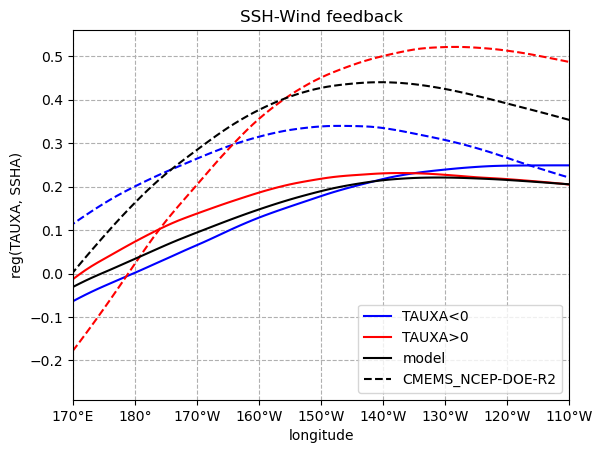

In [18]:

neg, pos = feedback_nonlin(model_tauu["ACCESS-ESM1-5"], model_zos["ACCESS-ESM1-5"])

qplt.plot(neg, color='blue', linestyle='solid', label='TAUXA<0')
qplt.plot(pos, color='red', linestyle='solid', label='TAUXA>0')

neg, pos = feedback_nonlin(obs_tauu["NCEP-DOE-R2"], obs_zos["CMEMS"])
qplt.plot(neg, color='blue', linestyle='--')
qplt.plot(pos, color='red', linestyle='--')

cb = lin_regress_matrix(model_zos["ACCESS-ESM1-5"], model_tauu["ACCESS-ESM1-5"])
        
qplt.plot(cb, color='black', linestyle='solid', label='model')

cb2 = lin_regress_matrix(obs_zos["CMEMS"], obs_tauu["NCEP-DOE-R2"])
qplt.plot(cb2, color='black', linestyle='--', label='CMEMS_NCEP-DOE-R2')

plt.xlim(170, 250)
plt.xlabel('longitude')
plt.ylabel('reg(TAUXA, SSHA)')
plt.grid(linestyle='--')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))
plt.legend()
plt.title("SSH-Wind feedback")


Figure 3: spatial structure sea surface height anomalies (SSHA) in the equatorial Pacific (meridional 5°S-5°N average; zonal 30° running average) regessed onto zonal wind stress anomalies (TauxA) in the western equatorial Pacific (Niño4 averaged), showing the possible nonlinearity in the strength of the Taux-to-SSH coupling (the reference shows the maximum coupling around 140°W, same position or slightly westward for TauxA<0, around 120°W for TauxA>0, with a stronger amplitude for TauxA>0; usually the models simulate a very small displacement of the maximum coupling for all TauxA, TauxA<0, TauxA>0 and simulate similar amplitude in each case). The black, red and blue lines and numbers show respectively linear regression computed for all TauxA, TauxA>0 and TauxA<0, the dashed and solid curves show respectively the reference and the model.

## Dive down level 4

In [19]:
from esmvalcore.preprocessor import climate_statistics, extract_month
import iris.plot as iplt

def feedback_nonlin_lvl4(sst_cube, tauu_cube):
    tauu_aux = tauu_cube.copy()
    sst_coord = iris.coords.AuxCoord(sst_cube.data, sst_cube.standard_name, sst_cube.long_name, sst_cube.var_name, sst_cube.units)
    tauu_aux.add_aux_coord(sst_coord, 0)
    # print(sst_cube.standard_name, sst_cube.long_name, sst_cube.var_name, sst_cube.units)

    below0 = iris.Constraint(coord_values={sst_cube.standard_name:lambda cell: cell < 0})
    above0 = iris.Constraint(coord_values={sst_cube.standard_name:lambda cell: cell > 0})
    ssta_neg = mask_above_threshold(sst_cube.copy(), 0) #x<0
    ssta_pos = mask_below_threshold(sst_cube.copy(), 0) #x>0
    xbelow0 = tauu_aux.extract(below0)
    xabove0 = tauu_aux.extract(above0)
    
    outreg_cube = annual_structure_reg(xbelow0, ssta_neg)
    posreg_cube = annual_structure_reg(xabove0, ssta_pos)
    all_cube = annual_structure_reg(tauu_cube, sst_cube)

    return all_cube, posreg_cube, outreg_cube

def lin_regress_4(cubeA, cubeBsst):
    A_data = cubeA.data.reshape(cubeA.shape[0], -1)  # Shape (time, spatial_points)
    if cubeA.shape[0] == cubeBsst.shape[0]:
        B_data = cubeBsst.data.flatten() # or all
    else:
        B_data = cubeBsst.data.compressed() # compress masked

    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T

    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, A_data, rcond=None)
    return coefs[0]
    
def annual_structure_reg(nhf_cube, ts_cube):
    months_reg = []
    for i in range(1,13):
        #extract for both cubes
        nhf = extract_month(nhf_cube, month=i)
        ts = extract_month(ts_cube, month=i)
        coefs = lin_regress_4(nhf, ts)
        # collect array for months
        months_reg.append(coefs)

    # get month_number coordinate from an existing cube
    m_cube = climate_statistics(ts_cube, operator='max', period='month')
    
    #create cube, x = months, y = lon
    result_cube = iris.cube.Cube(np.array(months_reg), long_name='regression',
                                 dim_coords_and_dims=[(nhf.coord('longitude'), 1), (m_cube.coord('month_number'), 0)])
    return result_cube  

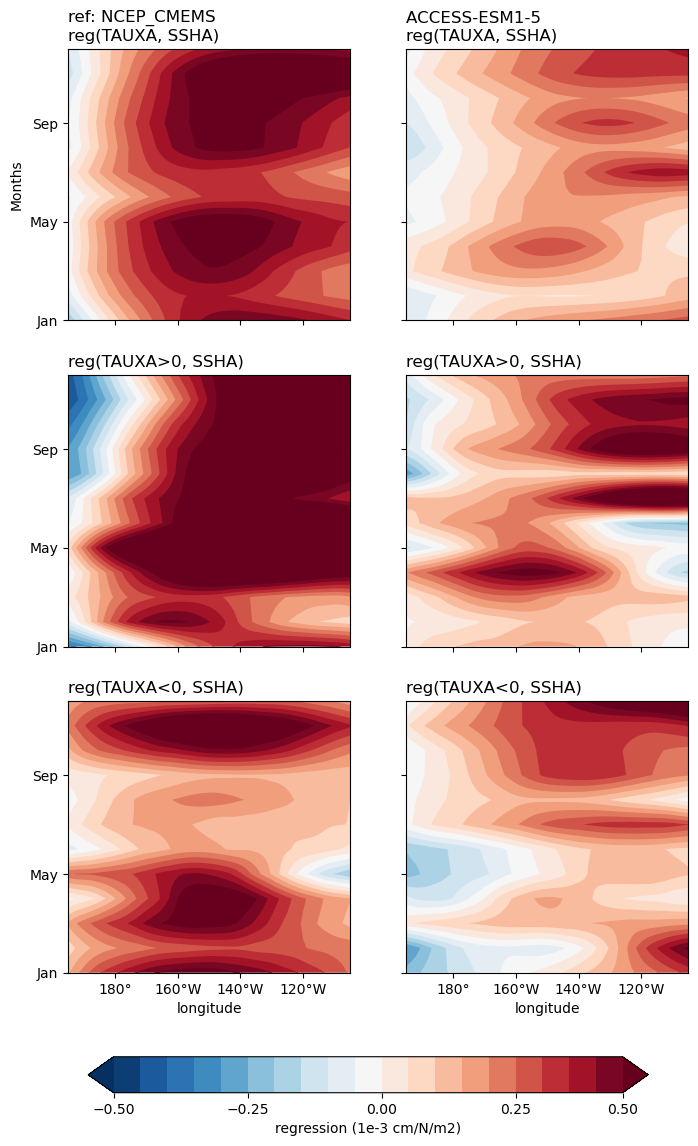

In [20]:
def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'

modells = feedback_nonlin_lvl4(model_tauu["ACCESS-ESM1-5"], model_zos["ACCESS-ESM1-5"])
obsls = feedback_nonlin_lvl4(obs_tauu["NCEP-DOE-R2"], obs_zos["CMEMS"])
sub = ['', '>0', '<0',] #all_cube, posreg_cube, outreg_cube

fig = plt.figure(figsize=(8, 12))
i = 321
ax1 = plt.subplot(i)

for isub, cbls in enumerate(zip(obsls, modells)):
    # build ls 

    for cb in cbls:
        if i == 321:
            ax1.set_yticks(range(1, 13, 4))
            ax1.set_yticklabels(['Jan', 'May', 'Sep'] )
            ax1.set_ylabel('Months')
            ax1.set_title('ref: NCEP_CMEMS \nreg(TAUXA, SSHA)', loc='left')
        else:
            ax2 = plt.subplot(i, sharex=ax1, sharey=ax1)
            ax2.set_title(f'reg(TAUXA{sub[isub]}, SSHA)', loc='left')
            if i == 322:
                ax2.set_title('ACCESS-ESM1-5 \nreg(TAUXA, SSHA)', loc='left')


        ## contour plt data
        cf1 = iplt.contourf(cb, coords=['longitude','month_number'], levels=np.arange(-0.5, 0.5, 0.05), extend='both', cmap="RdBu_r")
        
        if i < 325:
            plt.tick_params('x', labelbottom=False)
        else:
            plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude)) #apply to bottom left =>325
            ax2.set_xlabel("longitude")
        
        if i%2 == 0:
            plt.tick_params(labelleft=False)
        
        i += 1


cax = plt.axes([0.15,0.01,0.7,0.03])
cbar = fig.colorbar(cf1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(-0.5, 0.51, 0.25))
cbar.set_label('regression (1e-3 cm/N/m2)')

Figure 4: spatio-mean annual structure of sea surface height anomalies (SSHA) in the equatorial Pacific (meridional 5°S-5°N average; zonal 30° running average) regessed onto zonal wind stress anomalies (TauxA) in the western equatorial Pacific (Niño4 averaged), showing the possible nonlinearity in the strength of the Taux-to-SSH coupling. For all TauxA, the reference shows two peaks in the coupling: spring and late-autumn, both located around 140°W. Usually the models do not simulate the spring peak and the autumn peak is too weak. For TauxA>0, the reference shows three peaks: spring, summer late-autumn, all mainly in the eastern Pacific but the spring peak is also present in the central Pacific. Usually the models do not simulate the spring peak and the summer-late-autumn is only one and too weak (here the three peaks are simulated but all are too weak, particularly during spring). For TauxA<0, the reference shows two peaks: spring and late-autumn, both in the central Pacific. Usually the models do not simulate the spring peak (or it is very weak) and the late-autumn peak is weak (here the spring peak has the right amplitude but happens too months later, the late-autumn peak is too strong, last too long and happens one or two months earlier). The first, second and third rows show respectively linear regression computed for all TauxA, TauxA>0 and TauxA<0, the left and right Hovmöllers show respectively the reference and the model.